In [1]:
import re
import string
import json
import pickle
from random import randint
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
from tqdm.notebook import tqdm
from numpy import array
from pickle import dump, load
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.util import ngrams
from sklearn.manifold import TSNE
%matplotlib inline

2025-06-17 15:17:02.276816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750173422.300124    1068 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750173422.307409    1068 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Define Helper Functions



In [2]:
# Load document
def load_doc(filename):
    """Load text file and return its content."""
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Clean document into tokens
def clean_doc(doc):
    """Clean text and return list of alphabetic tokens."""
    doc = doc.replace('--', ' ')
    tokens = doc.split()
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens]
    return tokens

# Save lines to file
def save_doc(lines, filename):
    """Save list of lines to a file, one per line."""
    data = '\n'.join(lines)
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(data)

# Load and Clean Text



In [3]:
# Define input file path
input_file = '/kaggle/input/republictxt/republic.txt'

# Load and clean text
print("Loading and cleaning text...")
raw_text = load_doc(input_file).lower()
print(f"Length of corpus: {len(raw_text)}")
tokens = clean_doc(raw_text)
print(f"Total Tokens: {len(tokens)}")
print(f"Unique Tokens: {len(set(tokens))}")

Loading and cleaning text...
Length of corpus: 566392
Total Tokens: 98626
Unique Tokens: 7818


# Word Frequency Distribution (Histogram)



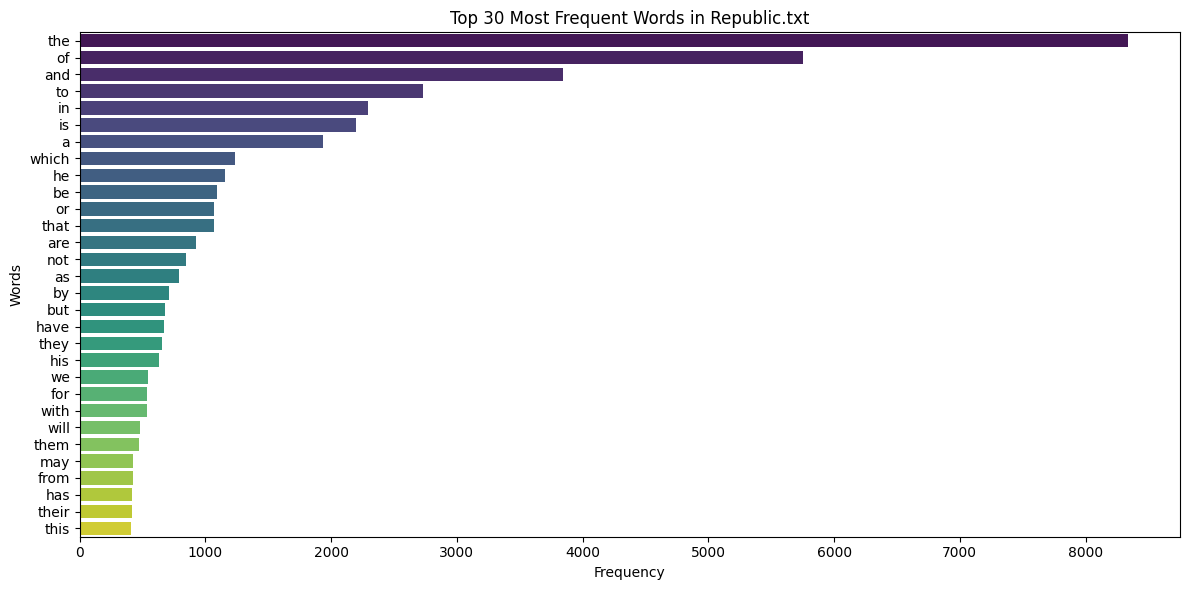

In [4]:
word_counts = Counter(tokens)
top_n = 30
common_words = word_counts.most_common(top_n)

# Convert to DataFrame for seaborn
df_common = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Plot histogram
plt.figure(figsize=(12, 6))
sns.barplot(data=df_common, x='Frequency', y='Word', palette='viridis')
plt.title('Top 30 Most Frequent Words in Republic.txt')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

# Word Cloud



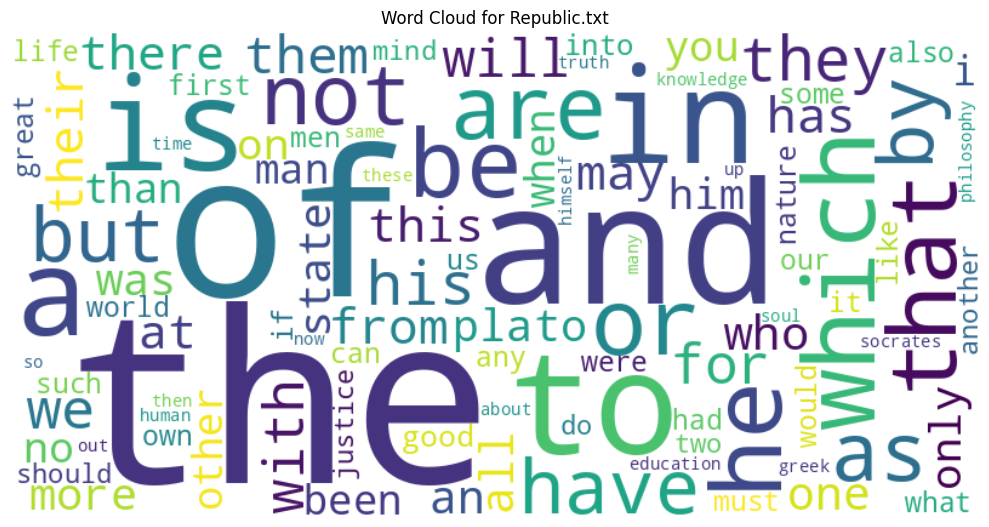

In [5]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(dict(word_counts))

# Plot word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Republic.txt')
plt.tight_layout()
plt.savefig('/kaggle/working/word_cloud.png')
plt.show()

# Token Length Distribution



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


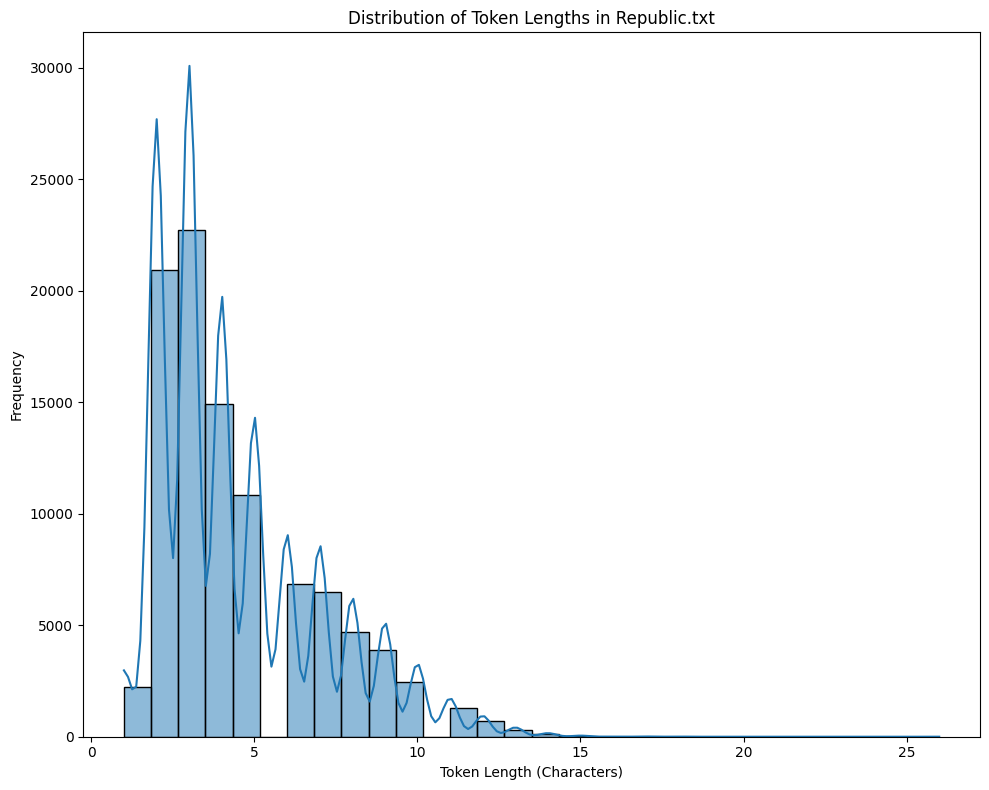

In [6]:
token_lengths = [len(token) for token in tokens]

# Plot histogram
plt.figure(figsize=(10, 8))
sns.histplot(token_lengths, bins=30, kde=True)
plt.title('Distribution of Token Lengths in Republic.txt')
plt.xlabel('Token Length (Characters)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('/kaggle/working/token_length_distribution.png')
plt.show()

# Create and Save Sequences



In [7]:
# Create sequences of length 50+1
length = 51
sequences = []
print("Creating sequences...")
for i in range(length, len(tokens)):
    seq = tokens[i-length:i]
    line = ' '.join(seq)
    sequences.append(line)
print(f"Total Sequences: {len(sequences)}")

# Save sequences
output_file = '/kaggle/working/republic_sequences.txt'
print(f"Saving sequences to {output_file}...")
save_doc(sequences, output_file)

Creating sequences...
Total Sequences: 98575
Saving sequences to /kaggle/working/republic_sequences.txt...


# Sequence Word Count Distribution



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


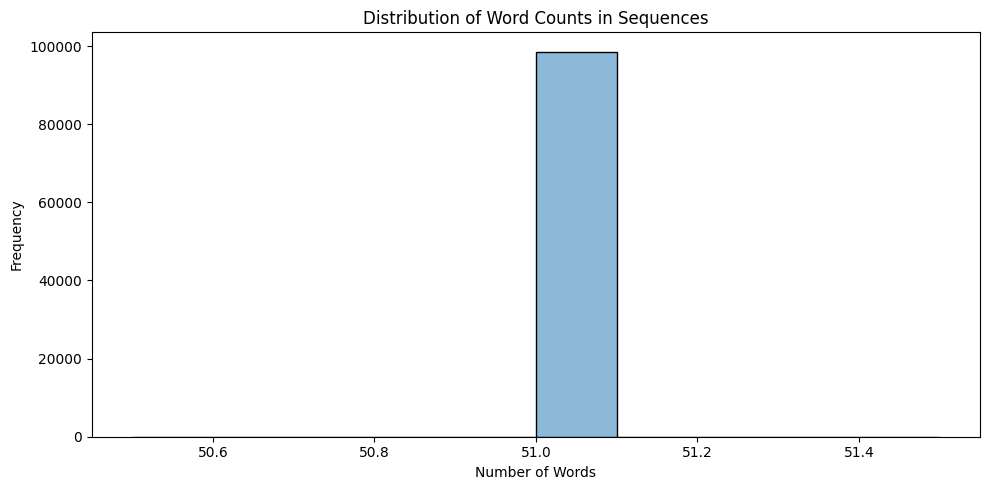

In [8]:
sequence_word_counts = [len(seq.split()) for seq in sequences]

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(sequence_word_counts, bins=10, kde=True)
plt.title('Distribution of Word Counts in Sequences')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('/kaggle/working/sequence_word_count.png')
plt.show()

#  N-Gram Frequency (Bigrams)



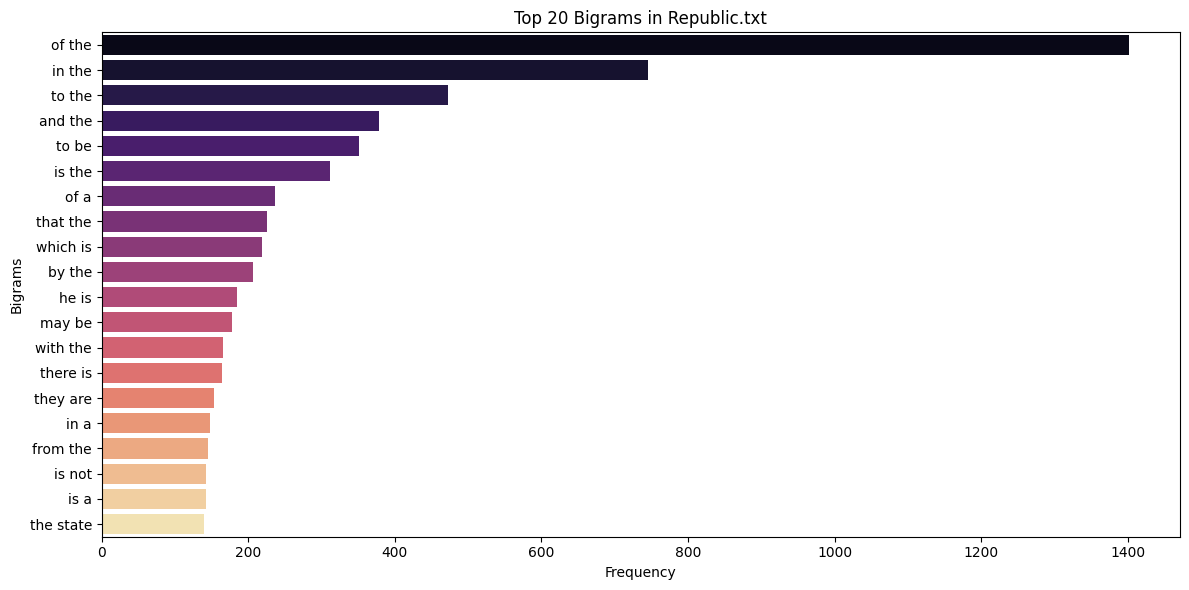

In [9]:
bigrams = list(ngrams(tokens, 2))
bigram_counts = Counter(bigrams)
top_n_bigrams = bigram_counts.most_common(20)

# Prepare data for plotting
bigram_labels = [' '.join(pair) for pair, _ in top_n_bigrams]
bigram_freqs = [freq for _, freq in top_n_bigrams]
df_bigrams = pd.DataFrame({'Bigram': bigram_labels, 'Frequency': bigram_freqs})

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_bigrams, x='Frequency', y='Bigram', palette='magma')
plt.title('Top 20 Bigrams in Republic.txt')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.tight_layout()
plt.savefig('/kaggle/working/bigram_frequency.png')
plt.show()

# Encode Sequences



In [10]:
# Load sequences
print("Loading sequences and encoding...")
doc = load_doc(output_file)
lines = doc.split('\n')

# Integer encode sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

# Prepare input/output
sequences = array(sequences)
X, y = sequences[:, :-1], sequences[:, -1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]
print(f"Input shape: {X.shape}, Label shape: {y.shape}")

Loading sequences and encoding...
Vocabulary Size: 7819
Input shape: (98575, 50), Label shape: (98575, 7819)


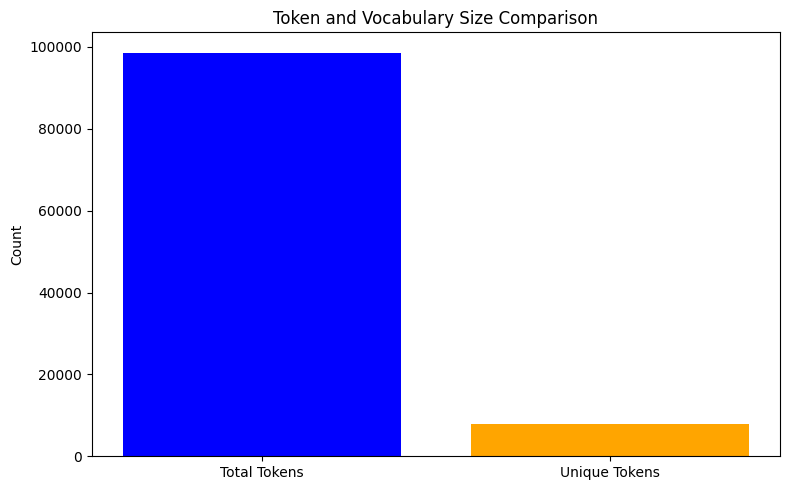

In [11]:
plt.figure(figsize=(8, 5))
plt.bar(['Total Tokens', 'Unique Tokens'], [len(tokens), len(set(tokens))], color=['blue', 'orange'])
plt.title('Token and Vocabulary Size Comparison')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('/kaggle/working/vocab_size.png')
plt.show()

# t-SNE for Word Embeddings 



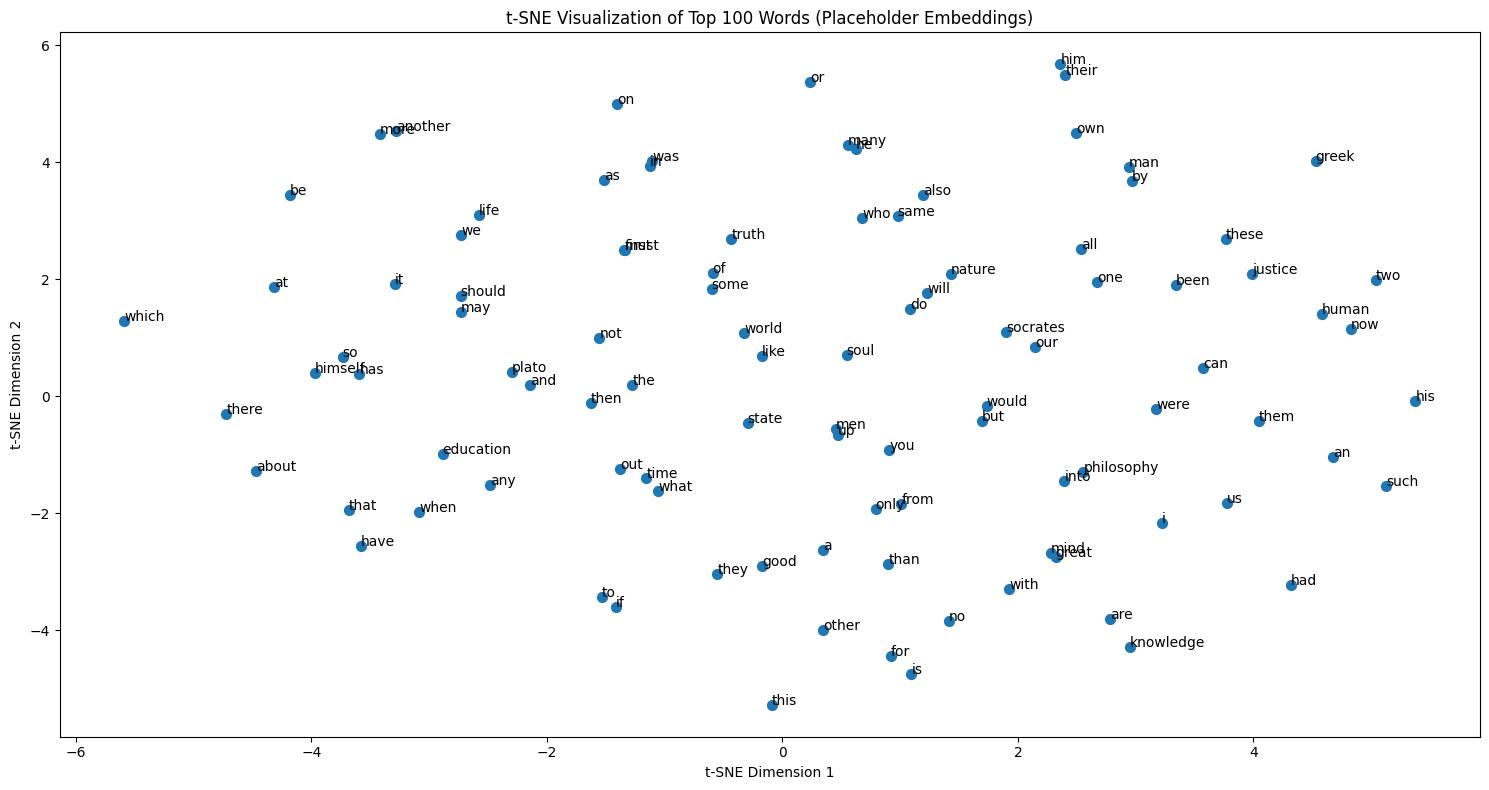

In [12]:
import numpy as np
embedding_dim = 50
embedding_matrix = np.random.rand(vocab_size, embedding_dim)  # Placeholder
top_n_words = 100
word_indices = list(tokenizer.word_index.values())[:top_n_words]
words = list(tokenizer.word_index.keys())[:top_n_words]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embedding_matrix[word_indices])

# Plot t-SNE
plt.figure(figsize=(15, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=50)
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=10)
plt.title('t-SNE Visualization of Top 100 Words (Placeholder Embeddings)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.savefig('/kaggle/working/tsne_embeddings.png')
plt.show()

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_shape=(seq_length,)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(50, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1750173435.506197    1068 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 50)              │         390,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7819)                │         398,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 832,669 (3.18 MB)

 Trainable params: 832,669 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history=model.fit(X,y,batch_size=64,epochs=100,shuffle=True)

Epoch 1/100


I0000 00:00:1750173450.906139    1121 cuda_dnn.cc:529] Loaded cuDNN version 90300


1541/1541 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.0882 - loss: 6.5967
Epoch 2/100
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.1281 - loss: 5.8744
Epoch 3/100
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.1462 - loss: 5.6460
Epoch 4/100
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.1553 - loss: 5.5244
Epoch 5/100
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.1662 - loss: 5.4030
Epoch 6/100
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.1736 - loss: 5.2856
Epoch 7/100
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.1822 - loss: 5.1632
Epoch 8/100
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.1883 - loss: 5.0640
Epoch 9/100
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.1920 - loss: 4.9583
Epoch 10/100
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.1983 - loss: 4.8748
Epoch 11/100
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.2019 - loss: 4.8255
Epoch 12/

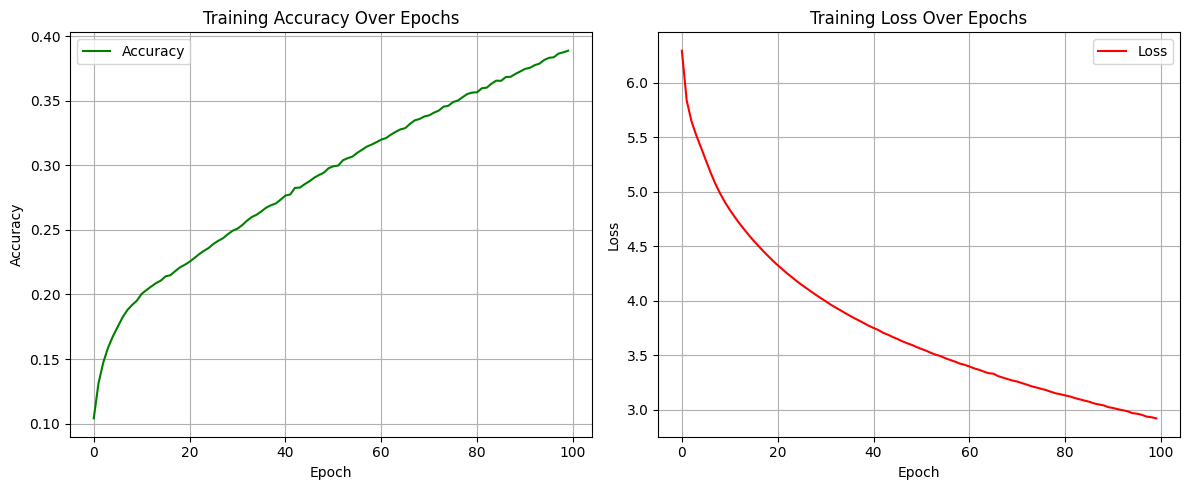

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy', color='green')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss', color='red')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
print("Saving tokenizer...")
file = open('/kaggle/working/tokenizer.pkl', 'wb')
pickle.dump(tokenizer, file)
file.close()

# Save Model
print("Saving model...")
model.save('/kaggle/working/model.keras')

Saving tokenizer...
Saving model...


# Define Helper Functions



In [17]:
def load_doc(filename):
    """Load text file and return its content."""
    file = open(filename, 'r', encoding='utf-8')
    text = file.read()
    file.close()
    return text

def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    """Generate a sequence of n_words from seed_text using the model."""
    result = []
    in_text = seed_text
    for _ in range(n_words):
        # Encode text as integers
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # Pad sequences to fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # Predict next word
        predict_x = model.predict(encoded, verbose=0)
        yhat = np.argmax(predict_x, axis=1)[0]
        # Map index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # Append to input and result
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

# Load Data and Generate Sequence



In [18]:
# Load sequences
in_filename = '/kaggle/working/republic_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1
print(f"Number of sequences: {len(lines)}")
print(f"Sample sequence: {lines[0]}")

# Load tokenizer and model
file = open('/kaggle/working/tokenizer.pkl', 'rb')
tokenizer = pickle.load(file)
file.close()
model = load_model('/kaggle/working/model.keras')

# Select random seed text
seed_text = lines[randint(0, len(lines))]
print(f"Seed text: {seed_text}\n")

# Generate 12 words
generated = generate_seq(model, tokenizer, seq_length, seed_text, 12)
print(f"Generated text: {generated}")

Number of sequences: 98575
Sample sequence: the project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or reuse it under the terms
Seed text: state for one is the best and the other the worst but which is the happier great and terrible as the tyrant may appear enthroned amid his satellites let us not be afraid to go in and ask and the answer is that the monarchical is the happiest and the tyrannical

Generated text: the spirited who hints at first sight appear for we have been


In [19]:
! pip freeze

absl-py==1.4.0
accelerate==1.5.2
aiofiles==22.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.18
aiosignal==1.3.2
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
alembic==1.15.2
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.7.1
arrow==1.3.0
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.3.31.0.36.18
asttokens==3.0.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
bayesian-optimization==2.0.3
beartype==0.20.2
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.2.1
blobfile==3.0.0
blosc2==3.2.1
bokeh==3.6.3
Boruta==0.4.3
boto3==1.38.11
botocore==1.38.11
Bottleneck==1.4.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper